<a href="https://colab.research.google.com/github/DannyData1419/CM3710-ML-AI/blob/main/CAR_EVALUATION_WITH_KMEANS_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import + preprocess

In [20]:
import pandas as pd

# Import data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
column_names = ['buying', 'maintenance', 'doors', 'persons', 'lug_boot', 'safety', 'class']

raw_dataset = pd.read_csv(url, names=column_names, skipinitialspace=True)
df = raw_dataset

# View sample of raw dataset
df.sample(10)

,buying,maintenance,doors,persons,lug_boot,safety,class
1658,low,low,3,4,small,high,good
1598,low,med,5more,2,med,high,unacc
487,high,vhigh,4,2,small,med,unacc
1702,low,low,5more,2,small,med,unacc
494,high,vhigh,4,2,big,high,unacc
900,med,vhigh,3,4,small,low,unacc
1675,low,low,4,2,small,med,unacc
125,vhigh,high,2,4,big,high,unacc
1195,med,low,2,2,big,med,unacc
1088,med,med,2,2,big,high,unacc


In [21]:
# See the shape of data
df.shape

(1728, 7)

In [22]:
# View columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   buying       1728 non-null   object
 1   maintenance  1728 non-null   object
 2   doors        1728 non-null   object
 3   persons      1728 non-null   object
 4   lug_boot     1728 non-null   object
 5   safety       1728 non-null   object
 6   class        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [23]:
# Provides the distribution of numerical data, applies basic statistical computations, missing values or NaN value is automatically skipped
df.describe()

,buying,maintenance,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [24]:
# Preprocess nominal features into numbers
import numpy as np

# One-hot-encode features
buying = pd.get_dummies(df['buying'])
maintenance = pd.get_dummies(df['maintenance'])
doors = pd.get_dummies(df['doors'])
persons = pd.get_dummies(df['persons'])
lug_boot = pd.get_dummies(df['lug_boot'])
safety = pd.get_dummies(df['safety'])

# Concat one-hot-encoded features to df
df = pd.concat((buying, maintenance, doors, persons, lug_boot, safety, df), axis=1)

# Drop original features from df 
df = df.drop(['buying', 'maintenance', 'doors', 'persons', 'lug_boot', 'safety'], axis=1)

# Create numbers for target variable
df['class'] = df['class'].replace({'vgood':1, 'good':2, 'acc':3, 'unacc':4})

In [25]:
# View sample of preprocessed dataset
df.sample(10)

,high,low,med,vhigh,high,low,med,vhigh,2,3,...,2,4,more,big,med,small,high,low,med,class
752,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,1,0,0,3
1237,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,2
639,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,4
1428,0,1,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,4
1006,0,0,1,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,4
1562,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,1,0,0,1
1242,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,4
874,0,0,1,0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,4
601,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,4
442,1,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,4


In [26]:
# Create target and features
X = df.drop('class', axis=1).values
y = df['class'].values

print(f"Features shape: {X.shape}\n{X}\n\nTarget shape: {y.shape}\n{y}")

Features shape: (1728, 21)
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [0 1 0 ... 0 1 0]
 [0 1 0 ... 0 0 1]
 [0 1 0 ... 1 0 0]]

Target shape: (1728,)
[4 4 4 ... 4 2 1]


# KMeans

In [27]:
# Data config for KMeans
data = X # put our features into data
labels = y # put our target into labels
n_classes = np.unique(y).size # count number of unique class labels 
n_samples = X.shape[0] # count number of samples
n_features = X.shape[1] # count number of features

print(f'# Classes: {n_classes}, # Samples: {n_samples}, # Features: {n_features}')

# Classes: 4, # Samples: 1728, # Features: 21


In [28]:
# We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. 
# Our benchmark will:
    # create a pipeline which will scale the data using a StandardScaler;
    # train and time the pipeline fitting;
    # measure the performance of the clustering obtained via different metrics.

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [29]:
# We will compare three approaches:
    # an initialization using kmeans++. This method is stochastic and we will run the initialization 4 times;
    # a random initialization. This method is stochastic as well and we will run the initialization 4 times;
    # an initialization based on a PCA projection. Indeed, we will use the components of the PCA to initialize KMeans. 
    # This method is deterministic and a single initialization suffice.

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_classes, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_classes, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_classes).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_classes, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.252s	29376	0.004	0.002	0.003	0.001	0.000	0.112
random   	0.126s	29376	0.080	0.048	0.060	0.013	0.058	0.112
PCA-based	0.011s	31507	0.197	0.123	0.151	0.109	0.149	0.059
__________________________________________________________________________________


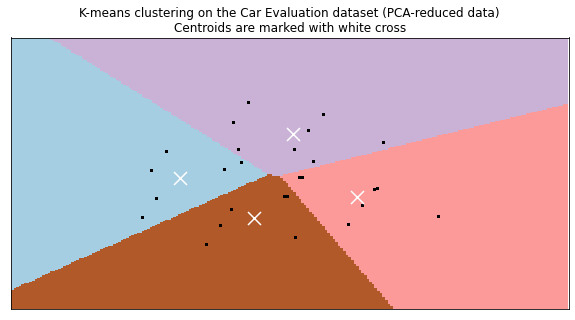

In [30]:
# PCA allows to project the data from the original 21-dimensional space into a lower dimensional space. Subsequently, 
# we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space.

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_classes, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, plt.figure(figsize=(10,5)))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the Car Evaluation dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()